In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_pytorch_vm/bin/python3.6


In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm import tqdm

import cv2
import torch
from torch.utils.data import Dataset

print("Python version used = ", sys.version)
print("OpenCV version = ", cv2.__version__)
print("PyTorch used = ", torch.__version__)

Python version used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
OpenCV version =  4.5.1
PyTorch used =  1.7.0+cu101


# Dataset : 

NIH Dataset images available at : "/media/HHD2/NIH/tflow_obj_detection/images"

Metadata for NIH is available at : "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

In [3]:
DATASET_PATH_NIH = "/media/HHD2/NIH/tflow_obj_detection/images/"
METADATA_PATH_NIH = "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

1 - Nodule
0 - Healthy

In [16]:
df = pd.DataFrame(pd.read_csv("filtered_metadata/metadata.csv"))

print(f"Shape of the dataframe = {df.shape}")

Shape of the dataframe = (66692, 5)


In [17]:
df.head()

,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66692 entries, 0 to 66691
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    66692 non-null  object
 1   label       66692 non-null  int64 
 2   patient_id  66692 non-null  int64 
 3   age         66692 non-null  int64 
 4   gender      66692 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.5+ MB


In [19]:
def load_image(base_path, image_name) : 
    image_path = os.path.join(base_path, image_name)
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [20]:
def resize_image(image, image_size) : 
    image = cv2.resize(image, (image_size[0], image_size[1]), interpolation = cv2.INTER_AREA)
    return image

# Load Random Images : 

In [21]:
random_image_names = [np.random.choice(os.listdir(DATASET_PATH_NIH)) for i in range(9)]

random_image_names

['00004520_000.png',
 '00022416_081.png',
 '00005736_002.png',
 '00014452_010.png',
 '00025091_001.png',
 '00021374_003.png',
 '00020438_016.png',
 '00004961_003.png',
 '00005372_021.png']

100%|██████████| 9/9 [00:01<00:00,  8.10it/s]


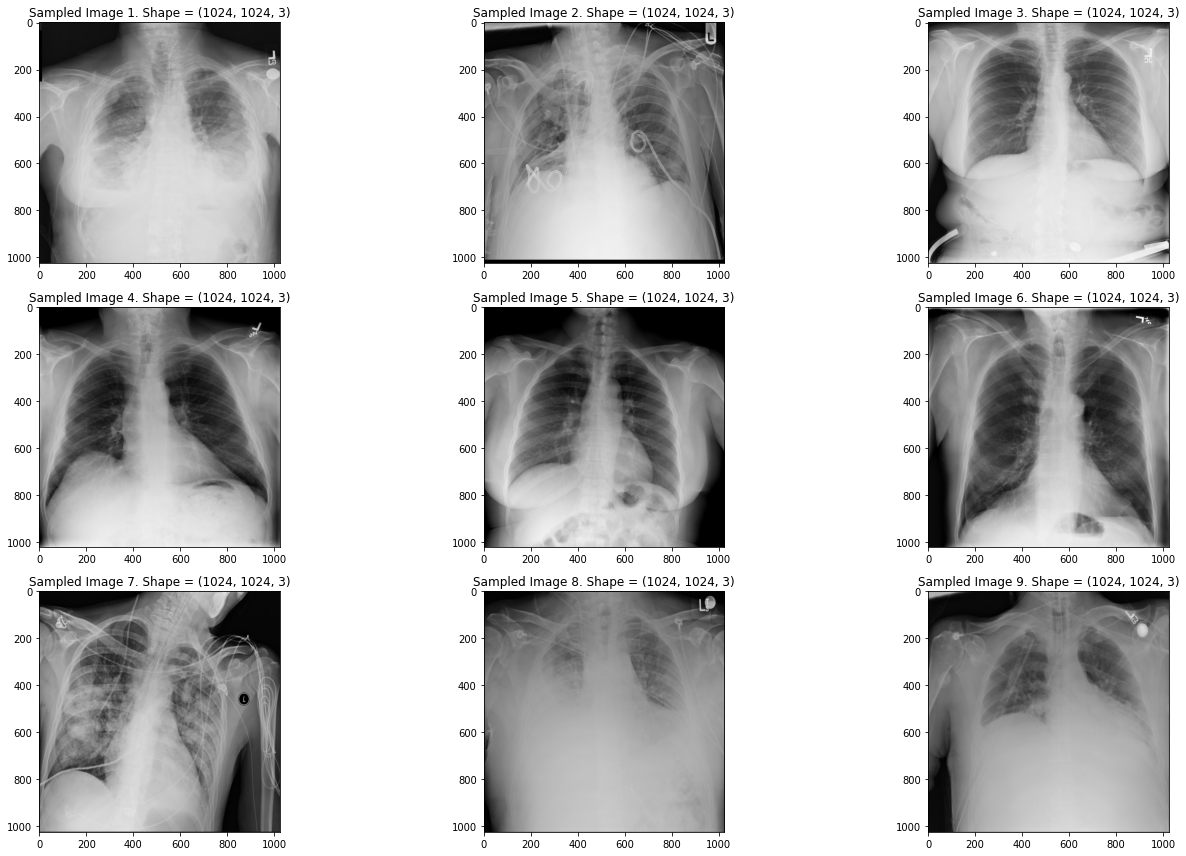

In [22]:
plt.figure(figsize = (20, 12))
for i in tqdm(range(9)) : 
    plt.subplot(3, 3, i+1)
    image = load_image(DATASET_PATH_NIH, random_image_names[i])
    plt.title(f"Sampled Image {i + 1}. Shape = {image.shape}")
    plt.imshow(image)
    plt.grid(False)

plt.tight_layout()

# Read Images & Labels

In [29]:
class ChestXRayDataset(Dataset) : 
    def __init__(self, data_dir, image_metadata_file, transform = None) : 
        """
        data_dir = path to the directory containing images.
        image_metadata_file = path to the metadata file(csv) containing images and labels.
        transform = optional parameter. If specified, the required transforms will be applied on the image.
        """
        image_names = []
        labels = []
        
        all_image_ids = image_metadata_file.image_id.values
        all_labels = image_metadata_file.label.values
        for (image_id, label) in zip(all_image_ids, all_labels) : 
            full_image_path = os.path.join(DATASET_PATH_NIH, image_id)
            image_names.append(full_image_path)
            labels.append(label)
        
        self.image_names = image_names
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index) : 
        """
        Upon passing the index, we get the corresponding image and labels.
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert("RGB")
        label = self.labels[index]
        if self.transform is not None : 
            image = self.transform(image)
        return image, torch.FloatTensor(label)
    
    def __len__(self) : 
        """
        Returns total number of images available.
        """
        return len(self.image_names)